In [1]:
import pandas as pd
import numpy as np
# read csv from panda
# train a regressor to predict the voltage
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from chemparse import parse_formula
# Mendeleev+
import matminer.featurizers.composition as comp
from matminer import featurizers
import matminer
from pymatgen.core import Composition


In [ ]:
train_df = pd.read_csv('../datasets/aflow/train.csv')
test_df = pd.read_csv('../datasets/aflow/test.csv')
val_df = pd.read_csv('../datasets/aflow/val.csv')

In [2]:
stats_list = ['minimum', 'maximum', 'range', 'mean', 'std_dev']
deml_list = ['molar_vol']
deml_f = comp.ElementProperty('deml', deml_list, stats_list)
magpie_list = ['Number', 'MendeleevNumber', 'AtomicVolume', 'AtomicWeight',
               'Column', 'Row', 'Density',
               'NdValence', 'NfValence',
               'NpValence', 'NsValence', 'NValence']
magpie_f = comp.ElementProperty('magpie', magpie_list, stats_list)
pymatgen_list = ['block', 'group']
pymatgen_f = comp.ElementProperty('pymatgen', pymatgen_list, stats_list)

def get_encoding_data(data_original, encoding_func):
    result = pd.DataFrame([])
    if type(data_original) == pd.DataFrame:
        for f in data_original.columns:
            result = result.join(encoding_func(data_original[f], suffix='_' + f), how='outer')
    else:
        result = encoding_func(data_original)
    # result['formula'] = data_original
    return result

def mendeleev_encoding(formulas, suffix=''):
    """
    in: formulas: an array-like of chemical formulas
    out: a dataframe of formula encoding
    """
    formulas_base = pd.Series(train_df['formula'])
    encoding_base = pd.DataFrame(formulas_base.apply(lambda x: parse_formula(x)).values.tolist())
    encoding_base = encoding_base.fillna(0).rename(columns=lambda x: x + suffix)
    if type(formulas) != pd.Series:
        formulas = pd.Series(formulas)
    encoding = pd.DataFrame(formulas.apply(lambda x: parse_formula(x)).values.tolist())
    encoding = encoding.fillna(0).rename(columns=lambda x: x + suffix)

    encoding = encoding.reindex(columns=encoding_base.columns, fill_value=0)
    return encoding

def get_matminer_features(f):
    try:
        features = deml_f.featurize(f) + magpie_f.featurize(f) + pymatgen_f.featurize(f)
        return np.array(features)
    except Exception:
        arr = np.zeros(75)
        arr[:] = np.nan
        return arr

In [3]:
# mendeleev_data = get_encoding_data(train_df['formula'], mendeleev_encoding)
mendeleev_train = get_encoding_data(train_df['formula'], mendeleev_encoding)
mendeleev_train = mendeleev_train.dropna()
mendeleev_val = get_encoding_data(val_df['formula'], mendeleev_encoding)
mendeleev_val = mendeleev_val.dropna()
mendeleev_test = get_encoding_data(test_df['formula'], mendeleev_encoding)
mendeleev_test = mendeleev_test.dropna()

In [4]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes = [128, 128, 128], random_state=0, max_iter=2000, activation='tanh', solver='adam', batch_size=16, validation_fraction=0).fit(
  mendeleev_train.to_numpy(), train_df['target'].to_numpy()
)

In [6]:
# best para: [400, 400, 400, 400]
preds = mlp.predict(mendeleev_test.to_numpy())
print("MAE: {}".format(mean_absolute_error(test_df['target'], preds)))
print("R2: {}".format(r2_score(test_df['target'], preds)))

MAE: 11.303296601931176
R2: 0.9057850640028311


In [ ]:
import generalized_rashomon_set as grs
explainer = grs.explainers.fis_explainer(mlp, input=mendeleev_test.to_numpy()
, output=test_df['target'].to_numpy()
, epsilon_rate=0.05, loss_fn='mean_absolute_error', n_order=2, delta=0.1, torch_input=False)

In [8]:
explainer.ref_explain()

2024-06-14 07:42:47,102 INFO _explainer ref_explain Reference model analysis
2024-06-14 07:42:47,102 INFO _explainer ref_explain Calculating main effect, joint effect and FIS for the reference model
2024-06-14 07:42:56,994 INFO _explainer ref_explain main effects calculated and can be called by explainer.ref_analysis[ref_main_effects]
2024-06-14 07:42:56,994 INFO _explainer ref_explain features with importance 0 are excluded, including []
2024-06-14 07:49:38,262 INFO _explainer _get_ref_fis joint effects calculated and can be called by explainer.ref_joint_effects
2024-06-14 07:49:38,264 INFO _explainer ref_explain FIS calculated and can be called by explainer.ref_analysis
2024-06-14 07:49:38,264 INFO _explainer ref_explain Calculation done


In [ ]:
explainer.ref_explain()

In [ ]:
explainer.rset_explain(interaction_effect=False)

## Plot the heat map

In [9]:
feature_names = mendeleev_train.columns.values

In [10]:
matrix = np.zeros((len(explainer.ref_analysis['ref_main_effects']),len(explainer.ref_analysis['ref_main_effects'])))

In [11]:
for i in explainer.ref_analysis['ref_fis']:
    matrix[i[0][0]][i[0][1]] = i[1]

In [12]:
for i in range(len(explainer.ref_analysis['ref_main_effects'])):
    matrix[i][i] = explainer.ref_analysis['ref_main_effects'][i]

In [13]:
matrix = matrix + matrix.T - np.diag(matrix.diagonal())
matrix = matrix[38:57,38:57]

In [14]:
mask = np.eye(matrix.shape[0], dtype=bool)

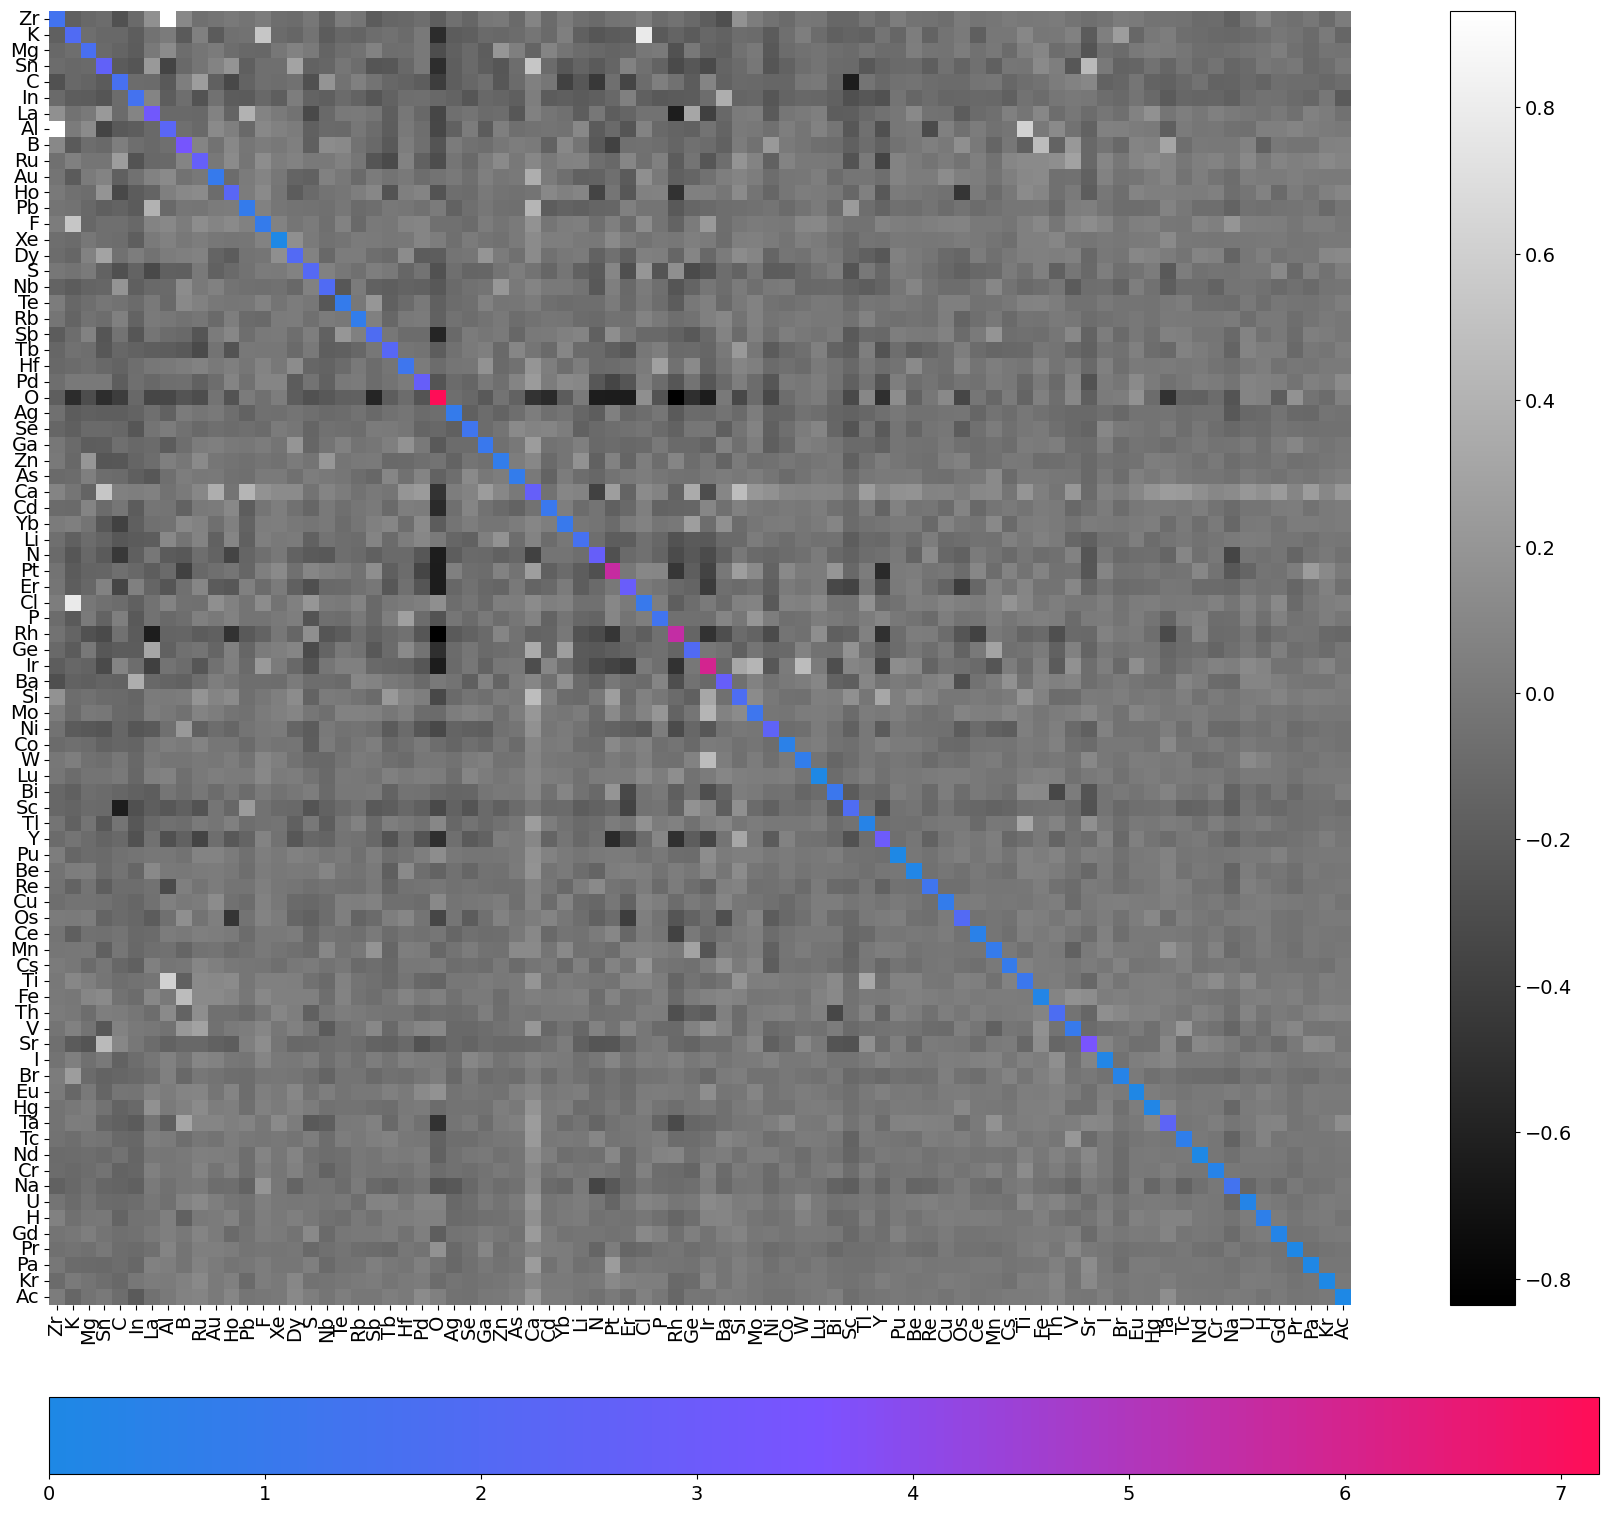

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
fig, ax = plt.subplots(figsize=(20,20))
plt.grid(False)
ax.grid(False)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#1E88E5", '#7C52FF', "#ff0d57"], N=180)
# norm = plt.Normalize(fis_in_r_df_long['Loss'].min(), explainer.loss + explainer.epsilon)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# Plot the heatmap for the diagonal
sns.heatmap(matrix, mask=~mask, cbar=False, cmap=cmap, xticklabels=feature_names, yticklabels=feature_names)

# Plot the heatmap for the rest
sns.heatmap(matrix, mask=mask, cbar=False, cmap='gray' , xticklabels=feature_names, yticklabels=feature_names)

# Create a colorbar at the top for the diagonal
cbar_top = fig.colorbar(ax.collections[0], ax=ax, orientation='horizontal', pad=0.01, anchor=(0.5, 0.5), )

# Create a colorbar at the right for the rest
cbar_right = fig.colorbar(ax.collections[1], ax=ax, orientation='vertical', pad=0.01, anchor=(0.5, 0.5))
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
cbar_top.ax.tick_params(labelsize=14)
cbar_right.ax.tick_params(labelsize=14)
# plt.savefig('Mendeleev-MLP-MR-heatmap-aflow.png', dpi=300, bbox_inches='tight')
plt.show()


## Plot the periodic table from https://github.com/Andrew-S-Rosen/periodic_trends

In [16]:
from periodic_trends import plotter
# Assuming mendeleev_data is your DataFrame and explainer.ref_analysis['ref_main_effects'] is your dictionary
main_effects = explainer.ref_analysis['ref_main_effects']

# Convert the dictionary and the column values into a DataFrame
df = pd.DataFrame(feature_names)
df = df.assign(column_values=main_effects)

# Save the DataFrame into a CSV file
df.to_csv('ele_importance_aflow.csv', index=False, header=False)


In [40]:
plt.style.use('default')
plotter("ele_importance_aflow.csv", cmap="viridis", output_filename='test.html', extended=True)

2024-06-24 15:13:01,210 INFO state output_file Session output file 'test.html' already exists, will be overwritten.


figure(id='p1179', ...)